# Birds Species Identifier - CNN Model

In [83]:
# Maybe needed

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
import seaborn as sns

#### Constantes modifiables

In [84]:
# A CHANGER EN FONCTION DE VOTRE SYSTEME D'EXPLOITATION

# Linux/Macos 
DATABASE_PATH = "../database"
# Windows
# DATABASE_PATH = "..\\database"

print(f"{DATABASE_PATH}")

../database


In [85]:
# Le nombre d'especes (classes) qu'on souhaite detecter
SPECIES_COUNT = 10

## Chargement des images 

In [86]:
import pandas as pd
from pathlib import Path

# Charger les images d'entrainement
dataset = f"{DATABASE_PATH}/train"
image_dir = Path(dataset)

# Prendre le chemin de chaque image et definir les labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatener les labels avec le chemin des images
image_df = pd.concat([filepaths, labels], axis=1)

# Lister toutes les especes uniques
all_species = image_df['Label'].unique()

# Recupere des especes aleatoires en fonction du nombre d'especes qu'on souhaite detecter
selected_species = random.sample(list(all_species), SPECIES_COUNT)

# Utiliser les especes selectionnees pour creer un dataframe
image_df = image_df[image_df['Label'].isin(selected_species)].reset_index(drop=True)

### Vérification des labels sur un groupe d'image aléatoires

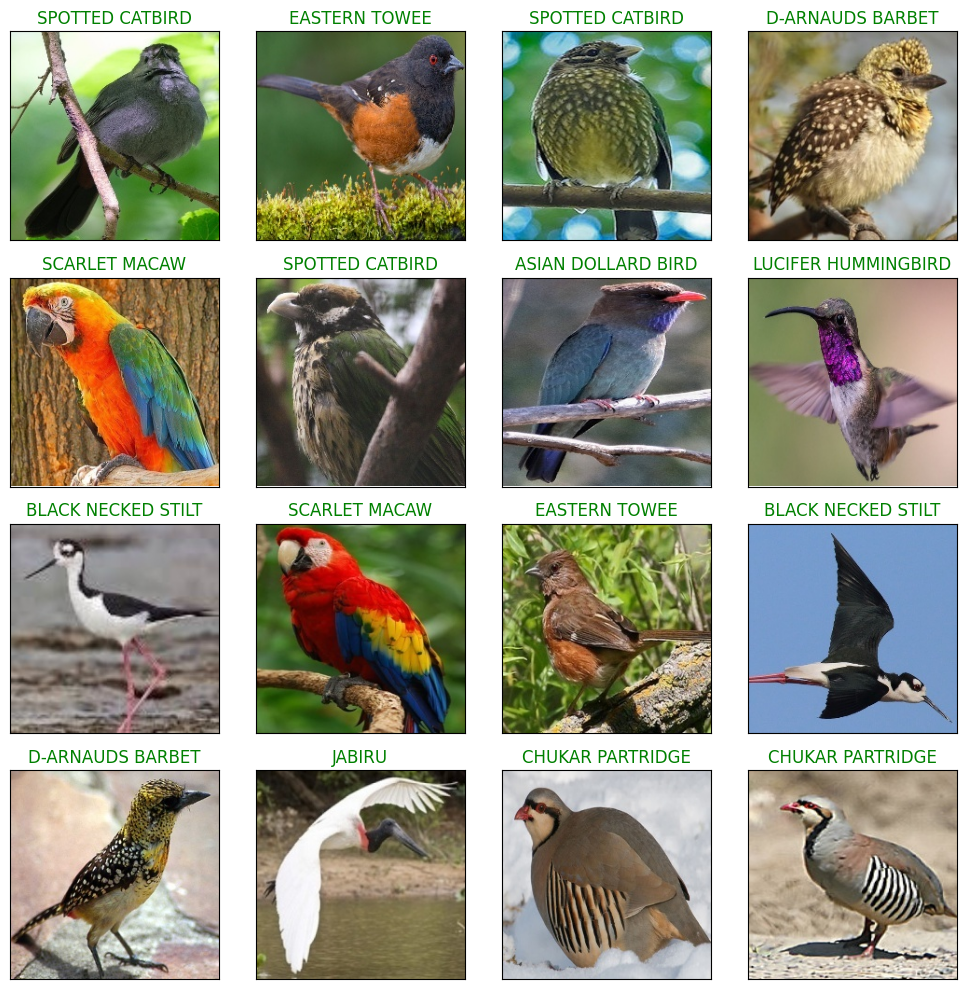

In [110]:
# Afficher 16 images aleatoires du dataset avec leur label
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]], color='green')
plt.tight_layout()
plt.show()

## Traitement des images avec ELA

In [88]:
from pathlib import Path
import random

# Définition de méthodes pour traiter les images avec ELA

# Calcule la différence absolue entre img1 et img2
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # lire les images compressées
    compressed_img = cv2.imread(temp_filename)

    # calculée la différence absolue entre img1 et img2 et multipliée par l'échelle
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff

# Converti une image en image ELA
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

# Prend un chemin de fichier et renvoie une image ELA
def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

### Visualization d'un exemple avec ELA

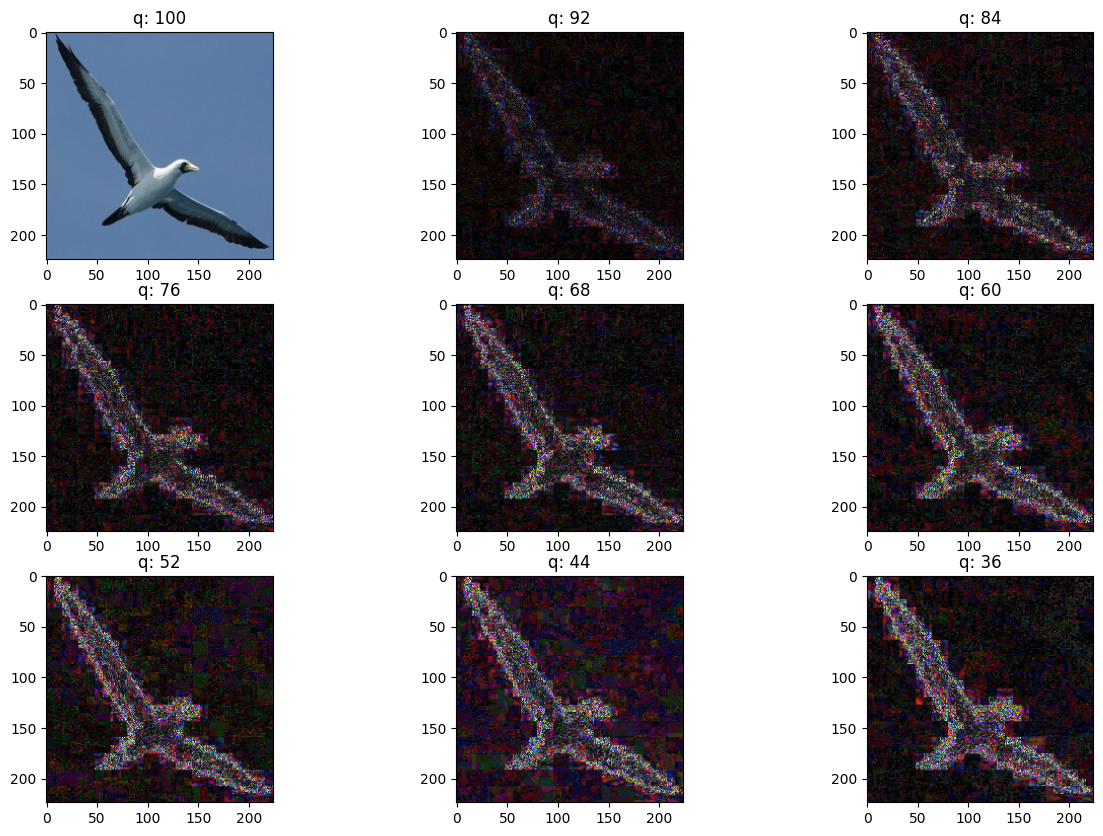

In [89]:
# Prendre un exemple aléatoire de l'oiseau MASKED BOOBY
p = random_sample(f"{DATABASE_PATH}/train/MASKED BOOBY")
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

In [90]:
import tensorflow as tf
# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

In [91]:
# Diviser le jeux de données en deux parties, une pour l'entrainement et l'autre pour le test
# La division est faite avec test_size=0.2, ce qui signifie que 20% des données sont utilisées pour le test
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)


## Pré-traitement des images
De façon similaire a ce que nous avons fait dans l'arbre binaire, on aimerai traité les images avant l'entrainement.

Contrairement au binary-tree, ici nous avons traité les images en utilisant le paramètre `preprocessing_function` de la classe `ImageDataGenerator` de la librairie __tensorflow__. Ce paramètre spécifie la fonction à utiliser pour le pré-traitement des images. Dans notre cas, nous utilisons la fonction `preprocess_input`, qui effectue des opérations de pré-traitement spécifiques à ce modèle, comme la normalisation.

In [92]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [93]:
# Division des données en données d'entrainement et de validation
# Les générateurs vont charger les images, les prétraiter (normalisation 
# spécifique à EfficientNet) et les fournir au modèle batch par batch.

# Générateur pour l'entraînement
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

# Générateur pour la validation
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

# Générateur pour les tests
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1065 validated image filenames belonging to 10 classes.
Found 266 validated image filenames belonging to 10 classes.
Found 333 validated image filenames belonging to 10 classes.


In [94]:
# Fonction pour augmenter les images
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

## Entrainement du model

In [95]:
# Charger le modèle pré-entraîné EfficientNetB0
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Rendre le modèle pré-entraîné non-entraînable (gelé)
pretrained_model.trainable = False

### Configuration des rappels (callbacks) pour l'entraînement du modèle

Cette section du code configure trois rappels importants pour l'entraînement du modèle:

`ModelCheckpoint` : Ce rappel sauvegarde les poids du modèle à des intervalles spécifiques, ce qui nous permet de les charger plus tard si nécessaire. Il est configuré pour sauvegarder uniquement les poids du modèle qui a la meilleure précision de validation.

`EarlyStopping` : Ce rappel arrête le processus d'entraînement si la perte de validation du modèle ne s'améliore pas pendant un certain nombre d'époques ( nous avons mis 5). Il restaure également les meilleurs poids du modèle lorsque l'entraînement est arrêté.

`ReduceLROnPlateau` : Ce rappel réduit le taux d'apprentissage lorsque la perte de validation cesse de s'améliorer. La réduction du taux d'apprentissage peut aider le modèle à converger et à trouver une meilleure solution.

In [96]:
# Création du callback de point de contrôle (checkpoint)
checkpoint_path = "birds_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Configuration du callback d'arrêt anticipé (EarlyStopping)
early_stopping = EarlyStopping(monitor = "val_loss", # surveiller la perte de validation
                               patience = 5, # arrêter l'entraînement si la perte de validation ne s'améliore pas pendant 5 époques
                               restore_best_weights = True) # restaurer les meilleurs poids du modèle si nécessaire

# Configuration du callback de réduction du taux d'apprentissage (ReduceLROnPlateau) 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


In [97]:
import datetime

# Définition d'une fonction pour créer un rappel TensorBoard
def create_tensorboard_callback(dir_name, experiment_name):
    # Création du répertoire de logs TensorBoard en fonction du nom du répertoire et du nom de l'expérience, ainsi que de la date et de l'heure actuelles
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
    # Création d'un objet TensorBoard callback avec le répertoire de logs spécifié
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir
    )
    
    # Affichage du chemin du répertoire de logs TensorBoard
    print(f"Saving TensorBoard log files to: {log_dir}")
    
    # Retourne le callback TensorBoard nouvellement créé
    return tensorboard_callback

In [98]:
# Nombre de epoch desiré
EPOCHS = 10

# Définition des entrées du modèle en utilisant les entrées du modèle pré-entraîné
inputs = pretrained_model.input

# Augmentation des données en utilisant une fonction d'augmentation
x = augment(inputs)

# Ajout d'une couche dense avec 128 neurones et une fonction d'activation ReLU
x = Dense(128, activation='relu')(pretrained_model.output)

# Ajout d'une couche de dropout pour régulariser le modèle en réduisant le surapprentissage
x = Dropout(0.45)(x)

# Ajout d'une autre couche dense avec 256 neurones et une fonction d'activation ReLU
x = Dense(256, activation='relu')(x)

# Ajout d'une autre couche de dropout pour régulariser le modèle
x = Dropout(0.45)(x)

# Ajout de la couche de sortie avec le nombre de classes (10)
outputs = Dense(SPECIES_COUNT, activation='softmax')(x)

# Création du modèle en spécifiant les entrées et les sorties
model = Model(inputs=inputs, outputs=outputs)

# Compilation du modèle avec l'optimiseur Adam, une faible valeur de taux d'apprentissage, la perte categorical_crossentropy pour la classification multi-classe
# et la métrique accuracy pour évaluer les performances du modèle
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entraînement du modèle avec les données d'entraînement et de validation, en spécifiant le nombre d'époques et les rappels à utiliser
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=EPOCHS,
    callbacks=[
        early_stopping,  # Arrêt anticipé pour éviter le surapprentissage
        create_tensorboard_callback("training_logs", "bird_classification"),  # Rappel TensorBoard pour visualiser les métriques d'entraînement
        checkpoint_callback,  # Rappel pour sauvegarder les meilleurs poids du modèle
        reduce_lr  # Rappel pour réduire le taux d'apprentissage si la perte de validation ne s'améliore pas
    ]
 )

Saving TensorBoard log files to: training_logs/bird_classification/20240209-162804
Epoch 1/10
34/34 [==============================] - 43s 1s/step - loss: 4.3097 - accuracy: 0.1371 - val_loss: 1.4926 - val_accuracy: 0.5564 - lr: 1.0000e-04
Epoch 2/10
34/34 [==============================] - 36s 1s/step - loss: 2.2300 - accuracy: 0.2808 - val_loss: 1.1189 - val_accuracy: 0.7519 - lr: 1.0000e-04
Epoch 3/10
34/34 [==============================] - 35s 1s/step - loss: 1.6809 - accuracy: 0.4028 - val_loss: 0.8541 - val_accuracy: 0.8346 - lr: 1.0000e-04
Epoch 4/10
34/34 [==============================] - 36s 1s/step - loss: 1.4274 - accuracy: 0.5174 - val_loss: 0.6318 - val_accuracy: 0.8797 - lr: 1.0000e-04
Epoch 5/10
34/34 [==============================] - 34s 991ms/step - loss: 1.1539 - accuracy: 0.6066 - val_loss: 0.4436 - val_accuracy: 0.9060 - lr: 1.0000e-04
Epoch 6/10
34/34 [==============================] - 33s 981ms/step - loss: 1.0351 - accuracy: 0.6507 - val_loss: 0.3232 - val_acc

## Evaluation du modèle

### Précision

In [103]:
# Take more than 6min
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))


Test Loss: 0.10979
Test Accuracy: 98.20%


### Prédiction des labels

In [100]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

11/11 [==============================] - 10s 764ms/step
The first 5 predictions: ['D-ARNAUDS BARBET', 'KILLDEAR', 'KILLDEAR', 'D-ARNAUDS BARBET', 'EASTERN TOWEE']


### Visualisation de images aléatoires et leurs label prédit

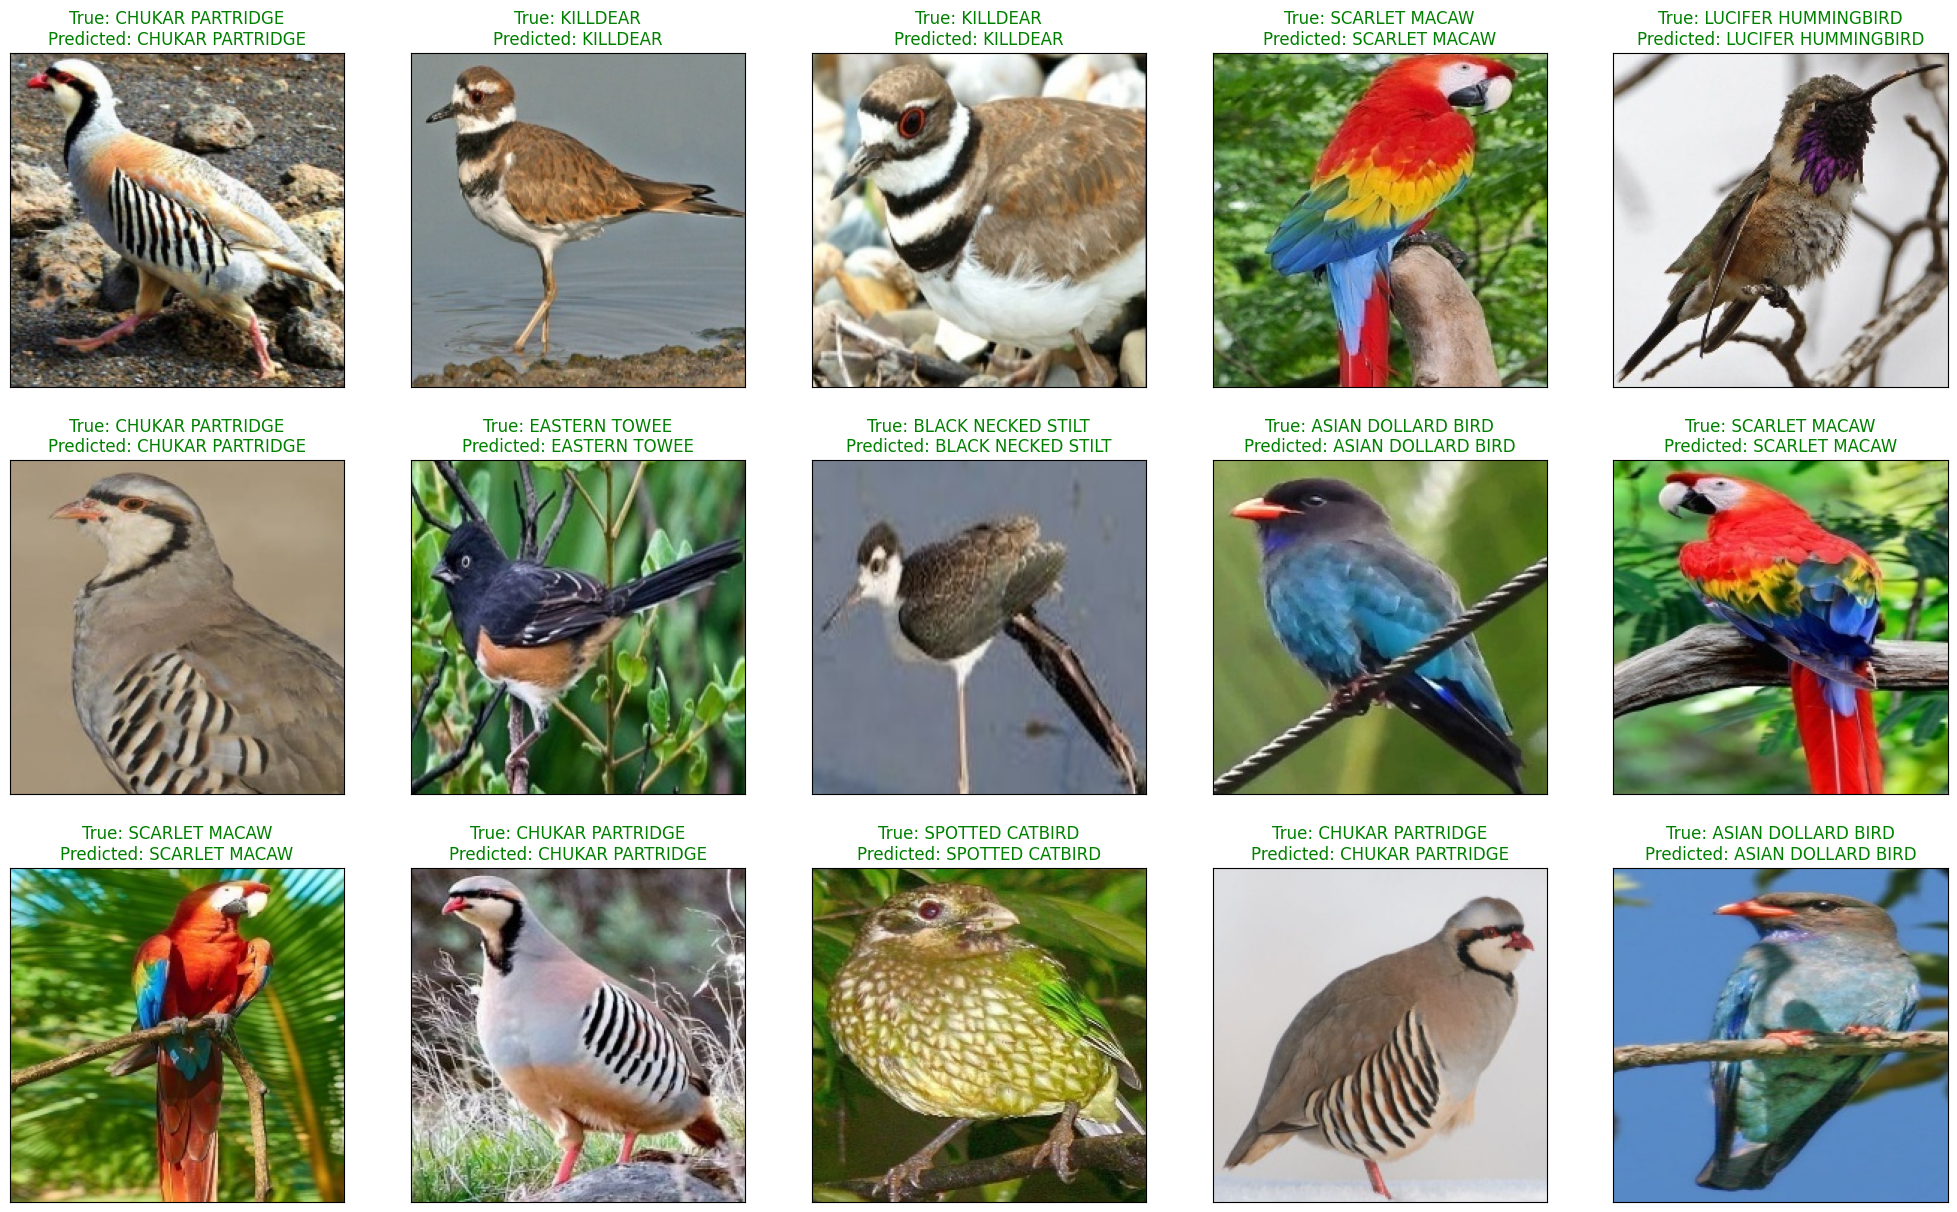

<Figure size 640x480 with 0 Axes>

In [109]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

## Visualisation graphique des resultat

### Matrice de confusion

### Courbe de précision

### Map de Caractéristiques (Features)